In [16]:
import numpy as np
import pandas as pd
import networkx as nx
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import igviz as ig
from node2vec import Node2Vec
from gensim.models import KeyedVectors
import seaborn as sns
import matplotlib.pyplot as plt
# import src.visualize as vis
# from src.visualize import visualize_celllevel_graph
# # import sys
# sys.path.append('./src/')
# sys.path.append('./src/submodules/CeSpGRN/src/')
# from src.preprocessing import construct_celllevel_graph
from plotly.subplots import make_subplots
# from src import models, training
# from torch_geometric.nn import GAE
import torch
import os
raw_data_path = "./data/"
starting_df = pd.read_csv(os.path.join(raw_data_path,f"seqfish_dataframe.csv"))

In [17]:
import plotly.graph_objects as go
import numpy as np
import plotly.express as px

def visualize_celllevel_graph(df, title, edge_trace=None, edge_weights=None, publication=False):
    # 使用 Plotly Express 绘制细胞散点图，所有点的颜色统一
    fig = px.scatter(df, x="X", y="Y", width=700, height=650,
                     color_discrete_sequence=["gray"],  # 设置所有点为统一灰色
                     title=title)  # 设置图表标题

    # 如果有边的坐标信息，添加边的描绘
    if edge_trace is not None and edge_weights is not None:
        edge_x, edge_y = edge_trace
        
        # 通过边的权重来调整边的宽度，确保宽度是单一的数值
        # 对权重进行归一化处理，计算宽度
        min_weight = min(edge_weights)
        max_weight = max(edge_weights)
        width_scale = 1  # 控制最大宽度（可以调整这个值来控制边的粗细）
        
        # 归一化处理每条边的宽度
        edge_widths = [(weight - min_weight) / (max_weight - min_weight) * width_scale + 1 for weight in edge_weights]
        
        # 设置边的宽度，如果有多个边宽，Plotly 需要统一处理
        # Plotly 只支持给每个边指定一个数值宽度，如果要设置不同宽度，可以给`line.width`传递一个比例值
        fig.add_trace(go.Scatter(
            x=edge_x, y=edge_y,
            line=dict(width=1, color='rgba(0, 0, 0, 0.3)'),  # 设置统一的边宽，Plotly需要的是统一数值
            hoverinfo='none',  # 不显示边的 hover 信息
            mode='lines',  # 仅显示线条
            name="Edges"))  # 边的名称

    # 更新点的显示样式
    fig.update_traces(
        marker=dict(
            size=6,  # 点的大小
            color='gray',  # 所有点统一为灰色
            opacity=0.8,  # 设置点的透明度
            line=dict(width=0)  # 去掉点的边框
        )
    )

    # 如果不需要出版风格，调整布局
    if not publication:
        fig.update_layout(coloraxis_colorbar=dict(yanchor="top", y=1, x=-0.2))  # 设置颜色条位置

        # 隐藏网格线和轴线背景
        fig.update_xaxes(showline=False, linewidth=2, linecolor='rgba(1,1,1,0)', gridcolor='rgba(1,1,1,0)', zeroline=False)
        fig.update_yaxes(showline=False, linewidth=2, linecolor='rgba(1,1,1,0)', gridcolor='rgba(1,1,1,0)', zeroline=False)

    # 设置出版风格的布局（清晰的白色背景，简洁的线条，去除不必要的元素）
    fig.update_layout(
        title=title,  # 设置标题
        title_x=0.5,  # 标题居中
        title_font=dict(size=24, family="Times New Roman", color="black"),  # 标题字体样式
        plot_bgcolor="white",  # 设置图表背景为白色
        paper_bgcolor="white",  # 设置纸张背景为白色
        font=dict(family="Times New Roman", color="black", size=16),  # 设置字体样式
        margin=dict(t=50, b=50, l=50, r=50),  # 留出适当的边距
        showlegend=False,  # 去除图例
        xaxis=dict(showline=True, linewidth=1, linecolor='black', ticks='outside', tickwidth=1, ticklen=5),  # X轴样式
        yaxis=dict(showline=True, linewidth=1, linecolor='black', ticks='outside', tickwidth=1, ticklen=5),  # Y轴样式
    )

    # 删除颜色轴（如果不需要）
    fig.update_coloraxes(showscale=False)

    return fig


In [18]:
import numpy as np

def construct_celllevel_graph_with_spatial_threshold_and_strength(data_df, k, tau=0.5, sigma=70, get_edges=False):
    '''
    Constructs a new cell graph with spatial proximity edges based on Euclidean distance and a spatial threshold.
    Also adds relationship strength based on spatial distance.

    :data_df: pd.DataFrame : represents the spatial data and contains the following columns ["Cell_ID", "X", "Y"]
    :k: int : Number of nearest neighbors to construct spatial edges for
    :tau: float : Threshold for the spatial distance to define biologically meaningful interactions
    :sigma: float : Standard deviation for Gaussian kernel (for strength calculation)
    :get_edges: boolean : True to return edge_trace (for visualization purposes)

    :return: Cell_level_adjacency, edge list, edge weights, network_relationship
    '''

    # Initialize adjacency matrix and edge lists
    num_cells = len(data_df)
    adjacency = np.zeros(shape=(num_cells,k), dtype=int)  # shape = (num_cells, num_neighbors)
    coords = np.vstack([data_df["X"].values, data_df["Y"].values]).T  # Cell coordinates

    edges = None
    edge_x = []
    edge_y = []
    edge_weights = []  # To store the strength of each edge

    # Initialize network relationship matrix (all zeros initially)
    network_relationship = np.zeros((len(data_df), len(data_df)))

    for i in range(len(data_df)):  # Loop through each cell
        x0, y0 = data_df["X"].values[i], data_df["Y"].values[i]
        candidate_cell = coords[i]
        candidate_neighbors = coords
        euclidean_distances = np.linalg.norm(candidate_neighbors - candidate_cell, axis=1)

        # Step 1: Sort cells based on Euclidean distances in ascending order (ignore self)
        sorted_indices = np.argsort(euclidean_distances)[1:]  # Sort by distance (ascending), excluding self
        
        # Step 2: Apply threshold tau and select up to k neighbors
        valid_neighbors = [idx for idx in sorted_indices if euclidean_distances[idx]][:k]
        
        # Fill adjacency list with valid neighbors
        adjacency[i, :len(valid_neighbors)] = valid_neighbors
        
        if get_edges:
            for ncell in valid_neighbors:
                x1, y1 = data_df["X"].values[ncell], data_df["Y"].values[ncell]
                # Calculate Gaussian kernel-based edge strength based on spatial distance
                distance = euclidean_distances[ncell]
                strength = np.exp(- (distance ** 2) / (2 * sigma ** 2))  # Gaussian kernel for distance-based strength
                edge_weights.append(strength)
                
                # Update the network relationship matrix with strength values
                network_relationship[i, ncell] = strength
                network_relationship[ncell, i] = strength  # Symmetric matrix

                # Add edge coordinates for visualization
                edge_x.append(x0)
                edge_x.append(x1)
                edge_x.append(None)
                edge_y.append(y0)
                edge_y.append(y1)
                edge_y.append(None)

    # Return adjacency matrix, edge list, edge weights, and network relationship matrix
    edges = [edge_x, edge_y] if get_edges else None

    return adjacency, edges, edge_weights, network_relationship

celllevel_adj1, edges1, edge_weights1,network_relationship1 = construct_celllevel_graph_with_spatial_threshold_and_strength(
    starting_df, k=2, tau=50, sigma=70, get_edges=True
)
network_relationship1 = network_relationship1 * 10
# 使用可视化函数显示结果
sim_fig = visualize_celllevel_graph(
    starting_df, title="Cell_Interaction(Spatial)", edge_trace=edges1, edge_weights=edge_weights1, publication=True
)

sim_fig.show()


In [19]:
import plotly.graph_objects as go
import numpy as np
import plotly.express as px

def visualize_celllevel_graph(df, title, edge_trace=None, edge_weights=None, publication=False):
    # 使用 Plotly Express 绘制细胞散点图，所有点的颜色统一
    fig = px.scatter(df, x="X", y="Y", width=700, height=650,
                     color_discrete_sequence=["gray"],  # 设置所有点为统一灰色
                     title=title)  # 设置图表标题

    # 如果有边的坐标信息，添加边的描绘
    if edge_trace is not None and edge_weights is not None:
        edge_x, edge_y = edge_trace
        
        # 通过边的权重来调整边的宽度，确保宽度是单一的数值
        # 对权重进行归一化处理，计算宽度
        min_weight = min(edge_weights)
        max_weight = max(edge_weights)
        width_scale = 10  # 控制最大宽度（可以调整这个值来控制边的粗细）
        
        # 归一化处理每条边的宽度
        edge_widths = [(weight - min_weight) / (max_weight - min_weight) * width_scale + 1 for weight in edge_weights]
        
        # 设置边的宽度，如果有多个边宽，Plotly 需要统一处理
        # Plotly 只支持给每个边指定一个数值宽度，如果要设置不同宽度，可以给`line.width`传递一个比例值
        fig.add_trace(go.Scatter(
            x=edge_x, y=edge_y,
            line=dict(width=1, color='rgba(0, 0, 0, 0.3)'),  # 设置统一的边宽，Plotly需要的是统一数值
            hoverinfo='none',  # 不显示边的 hover 信息
            mode='lines',  # 仅显示线条
            name="Edges"))  # 边的名称

    # 更新点的显示样式
    fig.update_traces(
        marker=dict(
            size=6,  # 点的大小
            color='gray',  # 所有点统一为灰色
            opacity=0.8,  # 设置点的透明度
            line=dict(width=0)  # 去掉点的边框
        )
    )

    # 如果不需要出版风格，调整布局
    if not publication:
        fig.update_layout(coloraxis_colorbar=dict(yanchor="top", y=1, x=-0.2))  # 设置颜色条位置

        # 隐藏网格线和轴线背景
        fig.update_xaxes(showline=False, linewidth=2, linecolor='rgba(1,1,1,0)', gridcolor='rgba(1,1,1,0)', zeroline=False)
        fig.update_yaxes(showline=False, linewidth=2, linecolor='rgba(1,1,1,0)', gridcolor='rgba(1,1,1,0)', zeroline=False)

    # 设置出版风格的布局（清晰的白色背景，简洁的线条，去除不必要的元素）
    fig.update_layout(
        title=title,  # 设置标题
        title_x=0.5,  # 标题居中
        title_font=dict(size=24, family="Times New Roman", color="black"),  # 标题字体样式
        plot_bgcolor="white",  # 设置图表背景为白色
        paper_bgcolor="white",  # 设置纸张背景为白色
        font=dict(family="Times New Roman", color="black", size=16),  # 设置字体样式
        margin=dict(t=50, b=50, l=50, r=50),  # 留出适当的边距
        showlegend=False,  # 去除图例
        xaxis=dict(showline=True, linewidth=1, linecolor='black', ticks='outside', tickwidth=1, ticklen=5),  # X轴样式
        yaxis=dict(showline=True, linewidth=1, linecolor='black', ticks='outside', tickwidth=1, ticklen=5),  # Y轴样式
    )

    # 删除颜色轴（如果不需要）
    fig.update_coloraxes(showscale=False)

    return fig


In [20]:
sim_fig = visualize_celllevel_graph(
    starting_df, title="Cell_Interaction(Spatial)", edge_trace=edges1, edge_weights=edge_weights1, publication=True
)

sim_fig.show()


In [21]:
import numpy as np

def construct_celllevel_graph_top_edges(data_df, ligand_receptor_pairs, threshold=0.5, sigma=100, k=2, get_edges=True):
    """
    优化：基于多个配体-受体对的表达值构建细胞图，保留每个细胞的相互作用强度大于等于阈值的边，
    并根据细胞间的空间距离使用高斯核函数调整相互作用强度。每个细胞最多与k个细胞连接。

    :param data_df: pd.DataFrame : 代表空间数据，包含 ["Cell_ID", "X", "Y"] 和特征列
    :param ligand_receptor_pairs: list of tuples : 每个元组包含配体和受体的列名
    :param threshold: float : 相似度的最小阈值
    :param sigma: float : 高斯核的标准差，用于调整空间距离的影响
    :param k: int : 每个细胞最多与k个细胞连接
    :param get_edges: boolean : 是否返回 edge_trace（用于可视化）    
    :return: adjacency (2D array), edges (optional), edge_weights (optional), edge_weight_matrix
    """
    num_cells = len(data_df)
    adjacency = np.zeros((num_cells, k), dtype=int)  # 邻接矩阵：每个细胞最多与k个细胞连接
    edge_x, edge_y = [], []
    edge_weights = []  # 用于存储每条边的强度
    edge_weight_matrix = np.zeros((num_cells, num_cells))  # 初始化边权重矩阵

    # 提取细胞坐标
    coords = np.vstack([data_df["X"].values, data_df["Y"].values]).T

    # 对于每个配体-受体对，计算相互作用强度
    for ligand, receptor in ligand_receptor_pairs:
        # 提取配体和受体的表达值
        L_vals = data_df[ligand].values
        R_vals = data_df[receptor].values

        # 筛选出配体和受体表达值大于0的细胞ID
        valid_cells = (L_vals > 0) & (R_vals > 0)

        # 计算有效细胞之间的相互作用
        valid_cells_indices = np.where(valid_cells)[0]  # 获取有效细胞的索引

        # 计算所有细胞对的空间距离
        valid_coords = coords[valid_cells]
        distance_matrix = np.linalg.norm(valid_coords[:, np.newaxis] - valid_coords, axis=2)

        # 计算配体和受体之间的外积 (interaction strength)，只对有效细胞进行计算
        interaction_strength_matrix = np.outer(L_vals[valid_cells], R_vals[valid_cells])

        # 应用高斯核函数调整相互作用强度
        distance_matrix_exp = np.exp(- (distance_matrix ** 2) / (2 * sigma ** 2))
        adjusted_interaction_matrix = interaction_strength_matrix * distance_matrix_exp

        # 通过阈值筛选出相互作用强度大于阈值的细胞对
        for i in range(len(valid_cells_indices)):
            for j in range(i + 1, len(valid_cells_indices)):  # 只考虑每对细胞一次（避免重复计算）
                cell_i = valid_cells_indices[i]
                cell_j = valid_cells_indices[j]

                # 获取调整后的相互作用强度
                interaction_strength_adjusted = adjusted_interaction_matrix[i, j]

                if interaction_strength_adjusted >= threshold:
                    edge_weight_matrix[cell_i, cell_j] = interaction_strength_adjusted
                    edge_weight_matrix[cell_j, cell_i] = interaction_strength_adjusted  # 对称

                    # 如果需要边的坐标
                    if get_edges:
                        x0, y0 = data_df.loc[cell_i, ["X", "Y"]]
                        x1, y1 = data_df.loc[cell_j, ["X", "Y"]]
                        edge_x.extend([x0, x1, None])
                        edge_y.extend([y0, y1, None])
                        edge_weights.append(interaction_strength_adjusted)

        # 选择每个细胞最强的k个连接
        for i in range(num_cells):
            # 获取细胞i与其他细胞的所有相互作用强度
            strengths = edge_weight_matrix[i]
            # 按强度排序并选择前k个强连接
            sorted_indices = np.argsort(strengths)[-k:]
            # 将这些连接更新到邻接矩阵中
            adjacency[i, :] = (strengths[sorted_indices] >= threshold).astype(int)
            
    edges = [edge_x, edge_y] if get_edges else None
    return adjacency, edges, edge_weights, edge_weight_matrix

In [22]:
# 配体-受体对
ligand_receptor_pairs = [('Gdf5', 'Bmpr1b'),('Gdf2', 'Bmpr1b'),('Cdh1', 'Bmpr1b'),('Ctla4', 'Bmpr1b')]

# 调用函数构建细胞网络图
threshold = 0.05  # 设置阈值
celllevel_adj2, edges2, edge_weights2,network_relationship2 = construct_celllevel_graph_top_edges(starting_df, ligand_receptor_pairs, threshold=threshold, get_edges=True)

# 使用可视化函数显示结果
sim_fig = visualize_celllevel_graph(
    starting_df, title="Cell_Interaction(LR)", edge_trace=edges2, edge_weights=edge_weights2, publication=True
)

sim_fig.show()


In [23]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

def construct_celllevel_graph_similarity_optimized(data_df, k, threshold=0.5, get_edges=False):
    '''
    基于特征相似度和kNN方法构建细胞图，使用基因共表达作为背景信息。
    
    :param data_df: pd.DataFrame : 包含 ["Cell_ID", "X", "Y"] 和特征列的 DataFrame
    :param k: int: 用于构建空间边的最近邻个数
    :param threshold: float: 相似度的最小阈值，用于确定有效邻居 (0 < threshold <= 1)
    :param get_edges: boolean: 是否返回 edge_trace（用于可视化）
    
    :return: adjacency (2D array), edges (optional), edge_weights (optional), edge_weight_matrix (optional)
    '''
    # 第1步：数据预处理 - 选择仅包含数值型特征的列
    feature_df = data_df.drop(columns=["Cell_ID", "X", "Y", "Cell_Type"], errors='ignore')
    feature_df = feature_df.select_dtypes(include=[np.number])  # 仅选择数值型列
    
    # 第2步：数据标准化
    feature_matrix = feature_df.values
    feature_matrix = (feature_matrix - feature_matrix.mean(axis=0)) / feature_matrix.std(axis=0)  # Z-Score标准化

    # 第3步：可选PCA降维
    pca = PCA(n_components=50)  # 将维度降至50个主成分，提高效率
    feature_matrix_pca = pca.fit_transform(feature_matrix)
    
    # 第4步：计算余弦相似度
    similarity_matrix = cosine_similarity(feature_matrix_pca)
    
    # 第5步：初始化邻接矩阵和边列表
    num_cells = len(data_df)
    adjacency = np.zeros((num_cells, k), dtype=int)  # 邻接矩阵：每个细胞最多k个邻居
    edge_x, edge_y = [], []
    edge_weights = []  # 用于存储相似度作为边的权重
    edge_weight_matrix = np.zeros((num_cells, num_cells))  # 初始化边权重矩阵

    # 第6步：寻找k个最近邻
    for i in range(num_cells):
        similarities = similarity_matrix[i]
        similarities[i] = -1  # 排除自身相似度
        valid_neighbors = np.where(similarities >= threshold)[0]
        
        # 如果有效邻居少于k个，则取所有有效邻居
        if len(valid_neighbors) < k:
            neighbors = valid_neighbors
        else:
            neighbors = valid_neighbors[np.argsort(similarities[valid_neighbors])[-k:]]
        
        # 填充邻接矩阵
        adjacency[i, :len(neighbors)] = neighbors
        
        # 如果需要边的坐标，添加到边列表
        if get_edges:
            x0, y0 = data_df["X"].values[i], data_df["Y"].values[i]
            for ncell in neighbors:
                x1, y1 = data_df["X"].values[ncell], data_df["Y"].values[ncell]
                edge_x.extend([x0, x1, None])
                edge_y.extend([y0, y1, None])
                edge_weights.append(similarities[ncell])  # 存储相似度作为边的权重

                # 更新边权重矩阵
                edge_weight_matrix[i, ncell] = similarities[ncell]
                edge_weight_matrix[ncell, i] = similarities[ncell]  # 对称

    edges = [edge_x, edge_y] if get_edges else None
    return adjacency, edges, edge_weights, edge_weight_matrix

# 调用函数并获取结果
celllevel_adj3, edges3, edge_weights3, network_relationship3 = construct_celllevel_graph_similarity_optimized(starting_df, 2, 0.8, get_edges=True)

# 使用可视化函数显示结果
sim_fig = visualize_celllevel_graph(
    starting_df, title="Cell_Interaction_Similarity", edge_trace=edges3, edge_weights=edge_weights3, publication=True
)

sim_fig.show()


In [24]:
def construct_celllevel_graph_combined(data_df, network_relationships, k, threshold=0.7, get_edges=True):
    '''
    将多个网络关系矩阵合并为一个邻接图，考虑来自多个来源的交互。

    :param data_df: pd.DataFrame : 代表空间数据，包含 ["Cell_ID", "X", "Y"]
    :param network_relationships: list : 网络关系矩阵列表（如空间、配体-受体）
    :param k: int : 每个细胞的邻居数量
    :param threshold: float : 合并邻接矩阵的阈值（调整为所需的相似度水平）
    :param get_edges: boolean : 是否返回边的坐标（用于可视化）

    :return: 合并后的邻接矩阵、边列表、边权重、合并后的边权重矩阵
    '''
    num_cells = len(data_df)
    combined_adjacency = np.zeros((num_cells, k), dtype=int)  # 初始化合并后的邻接矩阵
    combined_edge_x, combined_edge_y = [], []
    combined_edge_weights = []  # 存储每条边的权重
    combined_edge_weight_matrix = np.zeros((num_cells, num_cells))  # 合并后的边权重矩阵

    # 对于每个细胞，考虑所有网络关系中的交互
    for i in range(num_cells):
        cell_neighbors = []

        # 步骤1: 计算所有关系矩阵中的综合相似度（对于每个细胞，结合所有关系矩阵）
        aggregated_scores = np.sum([relationship[i] for relationship in network_relationships], axis=0)  # 求和合并所有关系的得分
        
        # 步骤2: 查找综合得分大于阈值的邻居
        valid_neighbors = np.where(aggregated_scores >= threshold)[0]  # 根据综合得分筛选邻居
        cell_neighbors.extend(valid_neighbors[:k])  # 限制邻居数不超过k个
        
        # 步骤3: 更新合并后的邻接矩阵
        unique_neighbors = list(set(cell_neighbors))  # 去重后的邻居列表
        combined_adjacency[i, :min(len(unique_neighbors), k)] = unique_neighbors[:k]  # 确保最多取k个邻居
        
        # 步骤4: 收集边的细节用于可视化（可选）
        if get_edges:
            x0, y0 = data_df.loc[i, ["X", "Y"]]
            for ncell in unique_neighbors[:k]:  # 只取前k个邻居
                x1, y1 = data_df.loc[ncell, ["X", "Y"]]
                combined_edge_x.extend([x0, x1, None])
                combined_edge_y.extend([y0, y1, None])
                
                # 合并边权重（这里简单地将各网络的权重加和）
                combined_strength = sum([relationship[i, ncell] for relationship in network_relationships])
                combined_edge_weights.append(combined_strength)

                # 更新合并后的边权重矩阵
                combined_edge_weight_matrix[i, ncell] = combined_strength
                combined_edge_weight_matrix[ncell, i] = combined_strength  # 对称矩阵

    return combined_adjacency, [combined_edge_x, combined_edge_y] if get_edges else None, combined_edge_weights, combined_edge_weight_matrix
celllevel_adj4, edges4, combined_edge_weights, combined_edge_weight_matrix = construct_celllevel_graph_combined(
    starting_df, [network_relationship1, network_relationship2, network_relationship3], k=2, threshold=0.5, get_edges=True
)
# 显示结果（可视化）
combined_fig = visualize_celllevel_graph(
    starting_df, title="Cell_Interaction(Muti_view)", edge_trace=edges4, edge_weights=combined_edge_weights, publication=True
)

combined_fig.show()





In [25]:
print(f"边的坐标长度: {len(edges4[0])}")
print(f"边的坐标长度: {len(edges4[1])}")


边的坐标长度: 9471
边的坐标长度: 9471


边的坐标长度: 12468
边的坐标长度: 12468


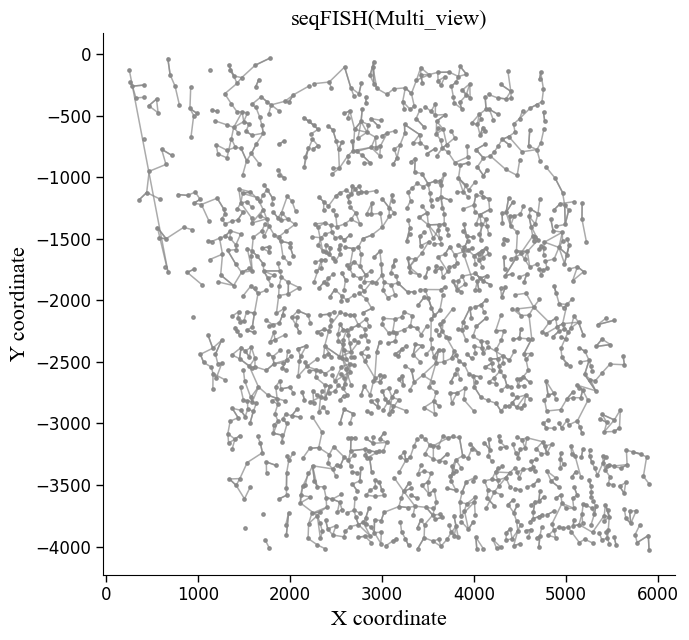

In [28]:
import matplotlib.pyplot as plt
import numpy as np
def construct_celllevel_graph_combined(data_df, network_relationships, k, threshold=0.7, get_edges=True):
    '''
    将多个网络关系矩阵合并为一个邻接图，考虑来自多个来源的交互。

    :param data_df: pd.DataFrame : 代表空间数据，包含 ["Cell_ID", "X", "Y"]
    :param network_relationships: list : 网络关系矩阵列表（如空间、配体-受体）
    :param k: int : 每个细胞的邻居数量
    :param threshold: float : 合并邻接矩阵的阈值（调整为所需的相似度水平）
    :param get_edges: boolean : 是否返回边的坐标（用于可视化）

    :return: 合并后的邻接矩阵、边列表、边权重、合并后的边权重矩阵
    '''
    num_cells = len(data_df)
    combined_adjacency = np.zeros((num_cells, k), dtype=int)  # 初始化合并后的邻接矩阵
    combined_edge_x, combined_edge_y = [], []
    combined_edge_weights = []  # 存储每条边的权重
    combined_edge_weight_matrix = np.zeros((num_cells, num_cells))  # 合并后的边权重矩阵

    # 对于每个细胞，考虑所有网络关系中的交互
    for i in range(num_cells):
        cell_neighbors = []

        # 步骤1: 计算所有关系矩阵中的综合相似度（对于每个细胞，结合所有关系矩阵）
        aggregated_scores = np.sum([relationship[i] for relationship in network_relationships], axis=0)  # 求和合并所有关系的得分
        
        # 步骤2: 查找综合得分大于阈值的邻居
        valid_neighbors = np.where(aggregated_scores >= threshold)[0]  # 根据综合得分筛选邻居
        cell_neighbors.extend(valid_neighbors[:k])  # 限制邻居数不超过k个
        
        # 步骤3: 更新合并后的邻接矩阵
        unique_neighbors = list(set(cell_neighbors))  # 去重后的邻居列表
        combined_adjacency[i, :min(len(unique_neighbors), k)] = unique_neighbors[:k]  # 确保最多取k个邻居
        
        # 步骤4: 收集边的细节用于可视化（可选）
        if get_edges:
            x0, y0 = data_df.loc[i, ["X", "Y"]]
            for ncell in unique_neighbors[:k]:  # 只取前k个邻居
                x1, y1 = data_df.loc[ncell, ["X", "Y"]]
                combined_edge_x.extend([x0, x1, None])
                combined_edge_y.extend([y0, y1, None])
                
                # 合并边权重（这里简单地将各网络的权重加和）
                combined_strength = sum([relationship[i, ncell] for relationship in network_relationships])
                combined_edge_weights.append(combined_strength)

                # 更新合并后的边权重矩阵
                combined_edge_weight_matrix[i, ncell] = combined_strength
                combined_edge_weight_matrix[ncell, i] = combined_strength  # 对称矩阵

    return combined_adjacency, [combined_edge_x, combined_edge_y] if get_edges else None, combined_edge_weights, combined_edge_weight_matrix
celllevel_adj4, edges4, combined_edge_weights, combined_edge_weight_matrix = construct_celllevel_graph_combined(
    starting_df, [network_relationship1, network_relationship2, network_relationship3], k=3, threshold=0.2, get_edges=True
)

# Enable interactive mode
plt.ion()

def visualize_celllevel_graph(df, title, edge_trace=None, edge_weights=1, publication=False):
    # Convert pixels to inches (for 100 DPI, 700px becomes 7 inches, 650px becomes 6.5 inches)
    figsize_in_inches = (700 / 100, 650 / 100)  # 700x650 pixels at 100 DPI
    
    # 创建一个新图形，设置大小为700x650像素（100 DPI）
    fig, ax = plt.subplots(figsize=figsize_in_inches)

    # 绘制细胞散点图，所有点的颜色统一为灰色
    ax.scatter(df["X"], df["Y"], color="gray", s=6, alpha=0.8, label="Cells")

    # 如果有边的坐标信息，添加边的描绘
    if edge_trace is not None:
        for i in range(0, len(edge_trace[0]), 2):
            x0, y0 = edge_trace[0][i], edge_trace[1][i]
            x1, y1 = edge_trace[0][i+1], edge_trace[1][i+1]
            ax.plot([x0, x1], [y0, y1], color='#888', lw=1.1, alpha=0.7)

    # 设置标题
    ax.set_title(title, fontsize=16, family="Times New Roman", color="black")
    ax.set_xlabel("X coordinate", fontsize=16, family="Times New Roman")
    ax.set_ylabel("Y coordinate", fontsize=16, family="Times New Roman")

    # 设置坐标轴样式
    ax.tick_params(axis='both', which='both', length=5, width=1, labelsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # 设置出版风格的布局（清晰的白色背景，简洁的线条，去除不必要的元素）
    if not publication:
        ax.grid(False)  # 隐藏网格线

    # 如果需要出版风格，设置白色背景和没有图例
    else:
        ax.set_facecolor("white")
        ax.legend().set_visible(False)

    # 保存图像，增加DPI以提高分辨率
    plt.tight_layout()  # 自动调整布局
    plt.savefig("MERFISH(Multi_view).png", dpi=300, bbox_inches='tight')  # 保存为高分辨率图像

    # 显示图形
    plt.show()

    return fig
print(f"边的坐标长度: {len(edges4[0])}")
print(f"边的坐标长度: {len(edges4[1])}")

sim_fig = visualize_celllevel_graph(
    starting_df, title="seqFISH(Multi_view)", edge_trace=edges4,
)


In [ ]:
[('Gdf5', 'Bmpr1B')]

In [29]:
import pandas as pd
import numpy as np
count_df = starting_df.drop(columns=['Cell_ID', 'X', 'Y', 'Cell_Type'])
def filter_gene_expression(count_df, expression_threshold=1.0, min_cells=100):
    """
    筛选表达量大于给定阈值的基因，并确保基因在至少 min_cells 个细胞中表达。
    此外，排除负数的基因表达值。
    """
    # 仅保留大于 expression_threshold 的基因表达值（大于0的基因表达）
    valid_gene_expression = count_df > expression_threshold  # 只筛选大于阈值的表达

    # 计算每个基因满足条件的细胞数
    cells_above_threshold = valid_gene_expression.sum(axis=0)  # 统计每个基因大于阈值的细胞数
    
    # 筛选出在至少 min_cells 个细胞中满足条件的基因
    filtered_count_df = count_df.loc[:, cells_above_threshold >= min_cells]
    
    return filtered_count_df

# 对 count_df 进行筛选
filtered_count_df = filter_gene_expression(count_df)
print(filtered_count_df.head())

def get_valid_cells(count_df, gene1, gene2, selected_cells):
    # 确保 selected_cells 是整数类型的列表，并转换为索引对象
    if isinstance(selected_cells, list) and all(isinstance(i, int) for i in selected_cells):
        selected_cells_index = count_df.index[selected_cells]  # 获取对应的索引
    else:
        selected_cells_index = selected_cells  # 如果已经是一个合适的索引

    # 筛选出配体基因表达大于1的细胞
    valid_cells_gene1 = count_df.loc[selected_cells_index, gene1] > 1  # 配体基因表达大于1
    valid_cells_gene1_ids = selected_cells_index[valid_cells_gene1].tolist()  # 配体基因有效细胞ID
    
    # 筛选出受体基因表达大于1的细胞
    valid_cells_gene2 = count_df.loc[selected_cells_index, gene2] > 1  # 受体基因表达大于1
    valid_cells_gene2_ids = selected_cells_index[valid_cells_gene2].tolist()  # 受体基因有效细胞ID
    
    return valid_cells_gene1_ids, valid_cells_gene2_ids

# 示例：获取 'Gdf5' 和 'Bmpr1b' 筛选后的细胞ID
selected_cells = list(filtered_count_df.index)  # 假设这些是您的有效细胞列表
gene1 = 'Gdf5'  # 替换为实际的基因名
gene2 = 'Bmpr1b'  # 替换为实际的基因名

#ligand="Gal", receptor="Galr1",
valid_cells_gene1_ids, valid_cells_gene2_ids = get_valid_cells(filtered_count_df, gene1, gene2, selected_cells)

print(f"Valid cells for ligand gene {gene1}: {valid_cells_gene1_ids}")
print(f"Valid cells for receptor gene {gene2}: {valid_cells_gene2_ids}")



   4931431F19Rik  4932429P05Rik  Abca15  Abca9  Adcy4  Aldh3b2  Ankle1  Ano7  \
0           1.83           1.52    2.41  -0.02  -0.28     1.95    0.04  0.10   
1           0.38          -0.04    0.59   0.03   0.93     0.49    0.08  2.05   
2           0.82           0.12    0.67  -0.29  -0.42    -0.04    1.35  0.68   
3           0.04          -1.27   -0.30  -0.52  -2.08     0.92   -0.03  0.42   
4           0.52           0.44   -1.05   0.48  -0.49     2.29    0.27  0.67   

   Anxa9  Arhgef26  ...  calb1   gda  slc5a7  sema3e  mfge8  lyve1  loxl1  \
0   0.91     -0.24  ...   0.12 -1.32   -2.06   -1.32   0.19  -2.20  -1.54   
1  -0.17     -0.11  ...  -1.60 -0.64   -2.47   -1.34   0.00   0.22  -1.46   
2   0.08      0.05  ...  -0.66 -0.78   -1.07   -2.09   0.09   0.32  -2.29   
3  -0.27      0.30  ...  -0.85 -1.16   -1.29   -0.57   0.99  -0.19  -1.49   
4  -1.00      0.43  ...  -0.65 -0.97   -1.29   -1.77   1.09  -1.17  -2.11   

   slco1c1  amigo2  kcnip  
0    -1.40    2.51   0.60  


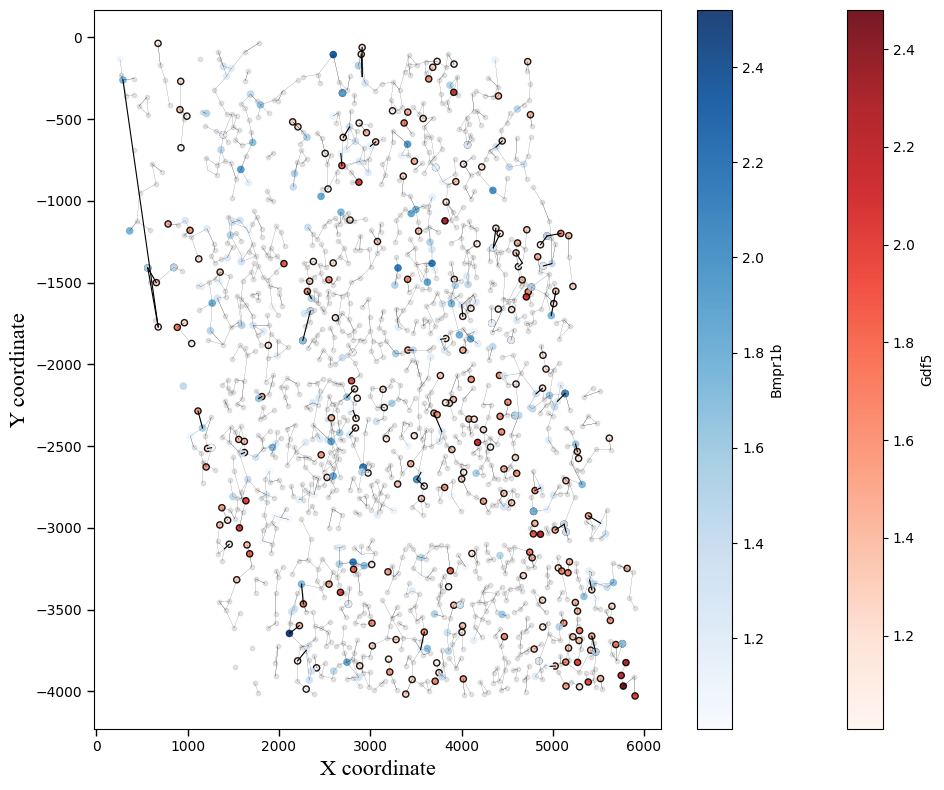

In [30]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_celllevel_graph_with_colored_nodes(df, edge_trace=None, edge_weights=None, 
                                                 selected_cells_1=None, selected_cells_2=None, 
                                                 gene1=None, gene2=None, figsize=(10, 8), 
                                                 markersize=10, xlim=None, ylim=None, publication=False):

    fig, ax = plt.subplots(figsize=figsize)

    # 获取 selected_cells_1 的 X 和 Y 坐标
    selected_cells_1_x = df.loc[selected_cells_1, 'X'].values
    selected_cells_1_y = df.loc[selected_cells_1, 'Y'].values
    selected_cells_2_x = df.loc[selected_cells_2, 'X'].values
    selected_cells_2_y = df.loc[selected_cells_2, 'Y'].values

    # 绘制背景细胞（未选中的细胞）
    all_cells = set(df.index)  
    background_cells = list(all_cells - set(selected_cells_1) - set(selected_cells_2))

    if background_cells:
        ax.scatter(df.loc[background_cells, 'X'], 
                   df.loc[background_cells, 'Y'],
                   s=10, color='gray', alpha=0.2, label="Background Cells")

    # 绘制配体基因表达最强的细胞
    if selected_cells_1 is not None and gene1 is not None:
        gene1_values = np.array(df.loc[selected_cells_1, gene1].values)
        scatter1 = ax.scatter(df.loc[selected_cells_1, 'X'], 
                              df.loc[selected_cells_1, 'Y'],
                              s=markersize, c=gene1_values, cmap='Reds', edgecolors='black',alpha=0.9,  label='Ligand Cells')
        fig.colorbar(scatter1, ax=ax, label=gene1)

    # 绘制受体基因表达最强的细胞
    if selected_cells_2 is not None and gene2 is not None:
        gene2_values = np.array(df.loc[selected_cells_2, gene2].values)
        scatter2 = ax.scatter(df.loc[selected_cells_2, 'X'], 
                              df.loc[selected_cells_2, 'Y'],
                              s=markersize, c=gene2_values, cmap='Blues', alpha=0.9, label='Receptor Cells')
        fig.colorbar(scatter2, ax=ax, label=gene2)

    # 清理 edge_trace 数据，提取有效的 edge_x 和 edge_y
    if edge_trace is not None:
        edge_x, edge_y = edge_trace  # 解包坐标数据

        # 遍历所有边的坐标，提取有效的坐标对
        for i in range(0, len(edge_x) - 1, 2):  # 确保不会超出范围
            x1, y1 = edge_x[i], edge_y[i]
            x2, y2 = edge_x[i + 1], edge_y[i + 1]

            # 检查每个端点是否在 selected_cells_1 和 selected_cells_2 中
            if (x1 in selected_cells_1_x and y1 in selected_cells_1_y) and (x2 in selected_cells_2_x and y2 in selected_cells_2_y):
                linewidth = 0.8  # 如果两端点都在 selected_cells_1 和 selected_cells_2 中，加粗边
            else:
                linewidth = 0.1  # 默认边宽

            # 绘制每一条边
            ax.plot([x1, x2], [y1, y2], color='black', lw=linewidth)

    # 设置坐标轴限制
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)

    # 设置出版风格的布局
    #ax.set_title("Cell-level Graph with Colored Nodes", fontsize=24, family="Times New Roman")
    ax.set_xlabel("X coordinate", fontsize=16, family="Times New Roman")
    ax.set_ylabel("Y coordinate", fontsize=16, family="Times New Roman")
    ax.tick_params(axis='both', which='both', length=5, width=1)


    # 显示图表
    plt.tight_layout()
    plt.show()

fig = visualize_celllevel_graph_with_colored_nodes(
    df=starting_df, 
    edge_trace=edges4,  # 边的坐标
    edge_weights=combined_edge_weights,  # 边的权重
    selected_cells_1=valid_cells_gene1_ids,  # 配体基因的细胞ID
    selected_cells_2=valid_cells_gene2_ids,  # 受体基因的细胞ID
gene1 = 'Gdf5',  # 替换为实际的基因名
gene2 = 'Bmpr1b',  # 替换为实际的基因名
    figsize=(10, 8),
    markersize=20
)



# 局部

C:\Users\R9000\AppData\Local\Temp\ipykernel_27440\758588102.py:83: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

C:\Users\R9000\AppData\Local\Temp\ipykernel_27440\758588102.py:87: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



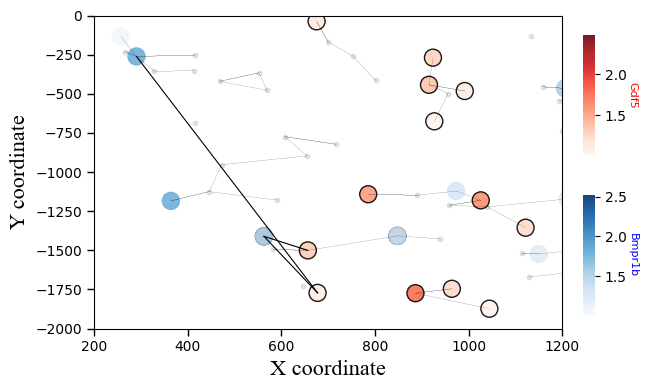

In [32]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_celllevel_graph_with_colored_nodes1(df, edge_trace=None, edge_weights=None, 
                                                 selected_cells_1=None, selected_cells_2=None, 
                                                 gene1=None, gene2=None, figsize=(10, 8), 
                                                 markersize=10, xlim=None, ylim=None, publication=False, save_path=None):

    fig, ax = plt.subplots(figsize=figsize)

    # 获取 selected_cells_1 的 X 和 Y 坐标
    selected_cells_1_x = df.loc[selected_cells_1, 'X'].values
    selected_cells_1_y = df.loc[selected_cells_1, 'Y'].values
    selected_cells_2_x = df.loc[selected_cells_2, 'X'].values
    selected_cells_2_y = df.loc[selected_cells_2, 'Y'].values

    # 绘制背景细胞（未选中的细胞）
    all_cells = set(df.index)  
    background_cells = list(all_cells - set(selected_cells_1) - set(selected_cells_2))

    if background_cells:
        ax.scatter(df.loc[background_cells, 'X'], 
                   df.loc[background_cells, 'Y'],
                   s=10, color='gray', alpha=0.2, label="Background Cells")

    # 绘制配体基因表达最强的细胞
    if selected_cells_1 is not None and gene1 is not None:
        gene1_values = np.array(df.loc[selected_cells_1, gene1].values)
        scatter1 = ax.scatter(df.loc[selected_cells_1, 'X'], 
                              df.loc[selected_cells_1, 'Y'],
                              s=markersize, c=gene1_values, cmap='Reds', edgecolors='black', alpha=0.9, label='Ligand Cells')

        # Adjust colorbar for gene1
        cbar_ax1 = fig.add_axes([0.98, 0.6, 0.02, 0.3])  # Manually place the colorbar for gene1
        cbar1 = plt.colorbar(scatter1, cax=cbar_ax1)
        cbar1.set_label(gene1, color='red', rotation=270, labelpad=8, fontsize=8)
        cbar1.outline.set_visible(False)  # Hide the outline of the colorbar

    # 绘制受体基因表达最强的细胞
    if selected_cells_2 is not None and gene2 is not None:
        gene2_values = np.array(df.loc[selected_cells_2, gene2].values)
        scatter2 = ax.scatter(df.loc[selected_cells_2, 'X'], 
                              df.loc[selected_cells_2, 'Y'],
                              s=markersize, c=gene2_values, cmap='Blues', alpha=0.9, label='Receptor Cells')

        # Adjust colorbar for gene2
        cbar_ax2 = fig.add_axes([0.98, 0.2, 0.02, 0.3])  # Manually place the colorbar for gene2
        cbar2 = plt.colorbar(scatter2, cax=cbar_ax2)
        cbar2.set_label(gene2, color='blue', rotation=270, labelpad=8, fontsize=8)
        cbar2.outline.set_visible(False)  # Hide the outline of the colorbar

    # 清理 edge_trace 数据，提取有效的 edge_x 和 edge_y
    if edge_trace is not None:
        edge_x, edge_y = edge_trace  # 解包坐标数据

        # 遍历所有边的坐标，提取有效的坐标对
        for i in range(0, len(edge_x) - 1, 2):  # 确保不会超出范围
            x1, y1 = edge_x[i], edge_y[i]
            x2, y2 = edge_x[i + 1], edge_y[i + 1]

            # 检查每个端点是否在 selected_cells_1 和 selected_cells_2 中
            if (x1 in selected_cells_1_x and y1 in selected_cells_1_y) and (x2 in selected_cells_2_x and y2 in selected_cells_2_y):
                linewidth = 0.8  # 如果两端点都在 selected_cells_1 和 selected_cells_2 中，加粗边
            else:
                linewidth = 0.1  # 默认边宽

            # 绘制每一条边
            ax.plot([x1, x2], [y1, y2], color='black', lw=linewidth)

    # 设置坐标轴限制
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)

    # 设置出版风格的布局
    ax.set_xlabel("X coordinate", fontsize=16, family="Times New Roman")
    ax.set_ylabel("Y coordinate", fontsize=16, family="Times New Roman")
    ax.tick_params(axis='both', which='both', length=5, width=1)

    # Save the plot to a file if save_path is provided
    if save_path:
        plt.tight_layout()
        plt.savefig(save_path, dpi=900, bbox_inches='tight')

   # Optionally, close the figure to avoid it being displayed interactively
    plt.tight_layout()
    plt.show()
    
    return fig

    # Call the function and save the plot
save_path = "Cell_Interaction_Graph.png"
fig = visualize_celllevel_graph_with_colored_nodes1(
        df=starting_df, 
        edge_trace=edges4,  # 边的坐标
        edge_weights=combined_edge_weights,  # 边的权重
        selected_cells_1=valid_cells_gene1_ids,  # 配体基因的细胞ID
        selected_cells_2=valid_cells_gene2_ids,  # 受体基因的细胞ID
    gene1 = 'Gdf5',  # 替换为实际的基因名
    gene2 = 'Bmpr1b',  # 替换为实际的基因名
        figsize=(6, 4),
        xlim=(200, 1200),
        ylim=(-2000,0),
        markersize=150,
        save_path=save_path  # Provide save path to save the figure
    )


In [ ]:
ligand_receptor_pairs = [('Gdf5', 'Bmpr1b'),('Gdf2', 'Bmpr1b'),('Cdh1', 'Bmpr1b'),('Ctla4', 'Bmpr1b')]

In [33]:
import pandas as pd
import numpy as np
count_df = starting_df.drop(columns=['Cell_ID', 'X', 'Y', 'Cell_Type'])
def filter_gene_expression(count_df, expression_threshold=1.0, min_cells=100):
    """
    筛选表达量大于给定阈值的基因，并确保基因在至少 min_cells 个细胞中表达。
    此外，排除负数的基因表达值。
    """
    # 仅保留大于 expression_threshold 的基因表达值（大于0的基因表达）
    valid_gene_expression = count_df > expression_threshold  # 只筛选大于阈值的表达

    # 计算每个基因满足条件的细胞数
    cells_above_threshold = valid_gene_expression.sum(axis=0)  # 统计每个基因大于阈值的细胞数
    
    # 筛选出在至少 min_cells 个细胞中满足条件的基因
    filtered_count_df = count_df.loc[:, cells_above_threshold >= min_cells]
    
    return filtered_count_df

# 对 count_df 进行筛选
filtered_count_df = filter_gene_expression(count_df)
print(filtered_count_df.head())

def get_valid_cells(count_df, gene1, gene2, selected_cells):
    # 确保 selected_cells 是整数类型的列表，并转换为索引对象
    if isinstance(selected_cells, list) and all(isinstance(i, int) for i in selected_cells):
        selected_cells_index = count_df.index[selected_cells]  # 获取对应的索引
    else:
        selected_cells_index = selected_cells  # 如果已经是一个合适的索引

    # 筛选出配体基因表达大于1的细胞
    valid_cells_gene1 = count_df.loc[selected_cells_index, gene1] > 1  # 配体基因表达大于1
    valid_cells_gene1_ids = selected_cells_index[valid_cells_gene1].tolist()  # 配体基因有效细胞ID
    
    # 筛选出受体基因表达大于1的细胞
    valid_cells_gene2 = count_df.loc[selected_cells_index, gene2] > 1  # 受体基因表达大于1
    valid_cells_gene2_ids = selected_cells_index[valid_cells_gene2].tolist()  # 受体基因有效细胞ID
    
    return valid_cells_gene1_ids, valid_cells_gene2_ids

# 示例：获取 'Gdf5' 和 'Bmpr1b' 筛选后的细胞ID
selected_cells = list(filtered_count_df.index)  # 假设这些是您的有效细胞列表
gene1 = 'Gdf2'  # 替换为实际的基因名
gene2 = 'Bmpr1b'  # 替换为实际的基因名

#ligand="Gal", receptor="Galr1",
valid_cells_gene1_ids, valid_cells_gene2_ids = get_valid_cells(filtered_count_df, gene1, gene2, selected_cells)

# print(f"Valid cells for ligand gene {gene1}: {valid_cells_gene1_ids}")
# print(f"Valid cells for receptor gene {gene2}: {valid_cells_gene2_ids}")

fig = visualize_celllevel_graph_with_colored_nodes(
    df=starting_df, 
    edge_trace=edges4,  # 边的坐标
    edge_weights=combined_edge_weights,  # 边的权重
    selected_cells_1=valid_cells_gene1_ids,  # 配体基因的细胞ID
    selected_cells_2=valid_cells_gene2_ids,  # 受体基因的细胞ID
gene1 = 'Gdf2',  # 替换为实际的基因名
gene2 = 'Bmpr1b',  # 替换为实际的基因名
    figsize=(10, 8),
    markersize=20
)


   4931431F19Rik  4932429P05Rik  Abca15  Abca9  Adcy4  Aldh3b2  Ankle1  Ano7  \
0           1.83           1.52    2.41  -0.02  -0.28     1.95    0.04  0.10   
1           0.38          -0.04    0.59   0.03   0.93     0.49    0.08  2.05   
2           0.82           0.12    0.67  -0.29  -0.42    -0.04    1.35  0.68   
3           0.04          -1.27   -0.30  -0.52  -2.08     0.92   -0.03  0.42   
4           0.52           0.44   -1.05   0.48  -0.49     2.29    0.27  0.67   

   Anxa9  Arhgef26  ...  calb1   gda  slc5a7  sema3e  mfge8  lyve1  loxl1  \
0   0.91     -0.24  ...   0.12 -1.32   -2.06   -1.32   0.19  -2.20  -1.54   
1  -0.17     -0.11  ...  -1.60 -0.64   -2.47   -1.34   0.00   0.22  -1.46   
2   0.08      0.05  ...  -0.66 -0.78   -1.07   -2.09   0.09   0.32  -2.29   
3  -0.27      0.30  ...  -0.85 -1.16   -1.29   -0.57   0.99  -0.19  -1.49   
4  -1.00      0.43  ...  -0.65 -0.97   -1.29   -1.77   1.09  -1.17  -2.11   

   slco1c1  amigo2  kcnip  
0    -1.40    2.51   0.60  


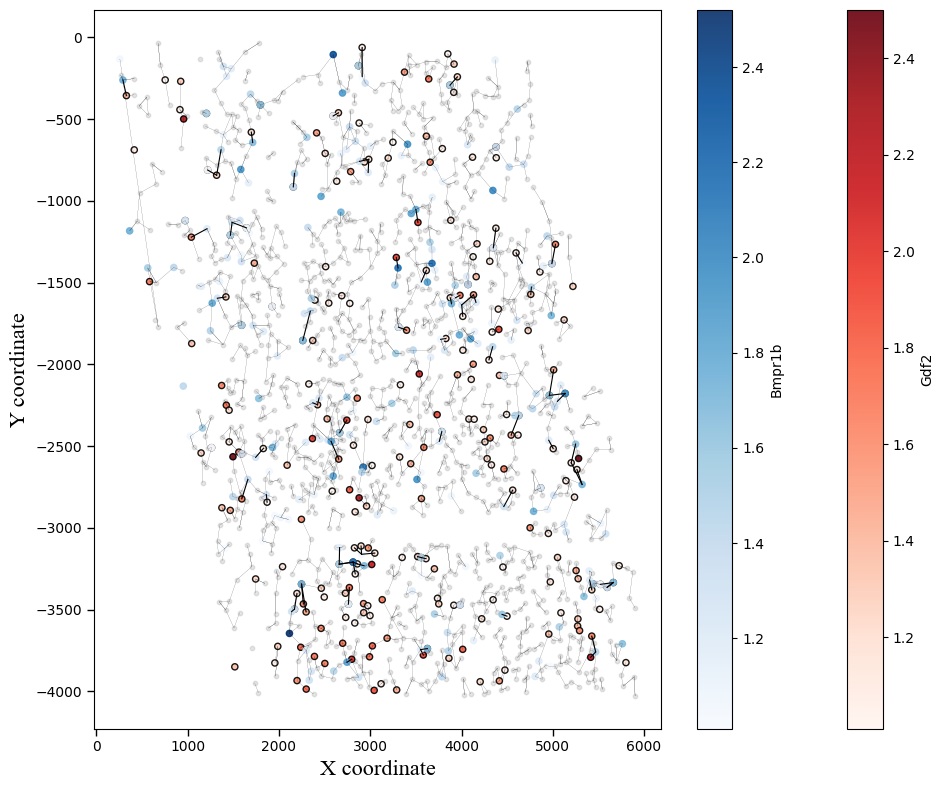

In [36]:
fig = visualize_celllevel_graph_with_colored_nodes(
    df=starting_df, 
    edge_trace=edges4,  # 边的坐标
    edge_weights=combined_edge_weights,  # 边的权重
    selected_cells_1=valid_cells_gene1_ids,  # 配体基因的细胞ID
    selected_cells_2=valid_cells_gene2_ids,  # 受体基因的细胞ID
gene1 = 'Gdf2',  # 替换为实际的基因名
gene2 = 'Bmpr1b',  # 替换为实际的基因名
    figsize=(10, 8),
    markersize=20
)


C:\Users\R9000\AppData\Local\Temp\ipykernel_27440\3581785589.py:83: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

C:\Users\R9000\AppData\Local\Temp\ipykernel_27440\3581785589.py:87: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



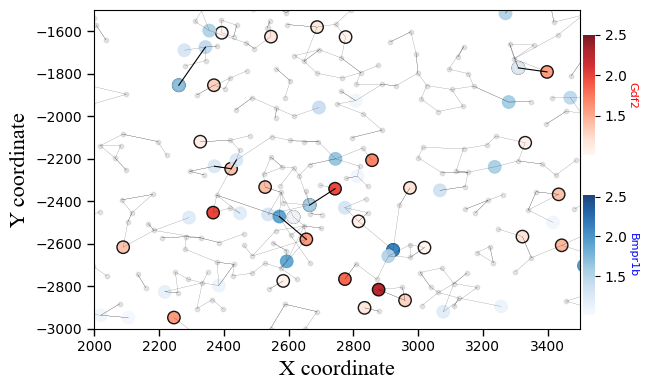

In [38]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_celllevel_graph_with_colored_nodes1(df, edge_trace=None, edge_weights=None, 
                                                 selected_cells_1=None, selected_cells_2=None, 
                                                 gene1=None, gene2=None, figsize=(10, 8), 
                                                 markersize=10, xlim=None, ylim=None, publication=False, save_path=None):

    fig, ax = plt.subplots(figsize=figsize)

    # 获取 selected_cells_1 的 X 和 Y 坐标
    selected_cells_1_x = df.loc[selected_cells_1, 'X'].values
    selected_cells_1_y = df.loc[selected_cells_1, 'Y'].values
    selected_cells_2_x = df.loc[selected_cells_2, 'X'].values
    selected_cells_2_y = df.loc[selected_cells_2, 'Y'].values

    # 绘制背景细胞（未选中的细胞）
    all_cells = set(df.index)  
    background_cells = list(all_cells - set(selected_cells_1) - set(selected_cells_2))

    if background_cells:
        ax.scatter(df.loc[background_cells, 'X'], 
                   df.loc[background_cells, 'Y'],
                   s=10, color='gray', alpha=0.2, label="Background Cells")

    # 绘制配体基因表达最强的细胞
    if selected_cells_1 is not None and gene1 is not None:
        gene1_values = np.array(df.loc[selected_cells_1, gene1].values)
        scatter1 = ax.scatter(df.loc[selected_cells_1, 'X'], 
                              df.loc[selected_cells_1, 'Y'],
                              s=markersize, c=gene1_values, cmap='Reds', edgecolors='black', alpha=0.9, label='Ligand Cells')

        # Adjust colorbar for gene1
        cbar_ax1 = fig.add_axes([0.98, 0.6, 0.02, 0.3])  # Manually place the colorbar for gene1
        cbar1 = plt.colorbar(scatter1, cax=cbar_ax1)
        cbar1.set_label(gene1, color='red', rotation=270, labelpad=8, fontsize=8)
        cbar1.outline.set_visible(False)  # Hide the outline of the colorbar

    # 绘制受体基因表达最强的细胞
    if selected_cells_2 is not None and gene2 is not None:
        gene2_values = np.array(df.loc[selected_cells_2, gene2].values)
        scatter2 = ax.scatter(df.loc[selected_cells_2, 'X'], 
                              df.loc[selected_cells_2, 'Y'],
                              s=markersize, c=gene2_values, cmap='Blues', alpha=0.9, label='Receptor Cells')

        # Adjust colorbar for gene2
        cbar_ax2 = fig.add_axes([0.98, 0.2, 0.02, 0.3])  # Manually place the colorbar for gene2
        cbar2 = plt.colorbar(scatter2, cax=cbar_ax2)
        cbar2.set_label(gene2, color='blue', rotation=270, labelpad=8, fontsize=8)
        cbar2.outline.set_visible(False)  # Hide the outline of the colorbar

    # 清理 edge_trace 数据，提取有效的 edge_x 和 edge_y
    if edge_trace is not None:
        edge_x, edge_y = edge_trace  # 解包坐标数据

        # 遍历所有边的坐标，提取有效的坐标对
        for i in range(0, len(edge_x) - 1, 2):  # 确保不会超出范围
            x1, y1 = edge_x[i], edge_y[i]
            x2, y2 = edge_x[i + 1], edge_y[i + 1]

            # 检查每个端点是否在 selected_cells_1 和 selected_cells_2 中
            if (x1 in selected_cells_1_x and y1 in selected_cells_1_y) and (x2 in selected_cells_2_x and y2 in selected_cells_2_y):
                linewidth = 0.8  # 如果两端点都在 selected_cells_1 和 selected_cells_2 中，加粗边
            else:
                linewidth = 0.1  # 默认边宽

            # 绘制每一条边
            ax.plot([x1, x2], [y1, y2], color='black', lw=linewidth)

    # 设置坐标轴限制
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)

    # 设置出版风格的布局
    ax.set_xlabel("X coordinate", fontsize=16, family="Times New Roman")
    ax.set_ylabel("Y coordinate", fontsize=16, family="Times New Roman")
    ax.tick_params(axis='both', which='both', length=5, width=1)

    # Save the plot to a file if save_path is provided
    if save_path:
        plt.tight_layout()
        plt.savefig(save_path, dpi=900, bbox_inches='tight')

   # Optionally, close the figure to avoid it being displayed interactively
    plt.tight_layout()
    plt.show()
    
    return fig

    # Call the function and save the plot
save_path = "Cell_Interaction_Graph.png"
fig = visualize_celllevel_graph_with_colored_nodes1(
        df=starting_df, 
        edge_trace=edges4,  # 边的坐标
        edge_weights=combined_edge_weights,  # 边的权重
        selected_cells_1=valid_cells_gene1_ids,  # 配体基因的细胞ID
        selected_cells_2=valid_cells_gene2_ids,  # 受体基因的细胞ID
    gene1 = 'Gdf2',  # 替换为实际的基因名
    gene2 = 'Bmpr1b',  # 替换为实际的基因名
        figsize=(6, 4),
        xlim=(2000, 3500),
        ylim=(-3000,-1500),
        markersize=80,
        save_path=save_path  # Provide save path to save the figure
    )


In [ ]:
ligand_receptor_pairs = [('Gdf5', 'Bmpr1b'),('Gdf2', 'Bmpr1b'),('Cdh1', 'Bmpr1b'),('Ctla4', 'Bmpr1b')]

   4931431F19Rik  4932429P05Rik  Abca15  Abca9  Adcy4  Aldh3b2  Ankle1  Ano7  \
0           1.83           1.52    2.41  -0.02  -0.28     1.95    0.04  0.10   
1           0.38          -0.04    0.59   0.03   0.93     0.49    0.08  2.05   
2           0.82           0.12    0.67  -0.29  -0.42    -0.04    1.35  0.68   
3           0.04          -1.27   -0.30  -0.52  -2.08     0.92   -0.03  0.42   
4           0.52           0.44   -1.05   0.48  -0.49     2.29    0.27  0.67   

   Anxa9  Arhgef26  ...  calb1   gda  slc5a7  sema3e  mfge8  lyve1  loxl1  \
0   0.91     -0.24  ...   0.12 -1.32   -2.06   -1.32   0.19  -2.20  -1.54   
1  -0.17     -0.11  ...  -1.60 -0.64   -2.47   -1.34   0.00   0.22  -1.46   
2   0.08      0.05  ...  -0.66 -0.78   -1.07   -2.09   0.09   0.32  -2.29   
3  -0.27      0.30  ...  -0.85 -1.16   -1.29   -0.57   0.99  -0.19  -1.49   
4  -1.00      0.43  ...  -0.65 -0.97   -1.29   -1.77   1.09  -1.17  -2.11   

   slco1c1  amigo2  kcnip  
0    -1.40    2.51   0.60  


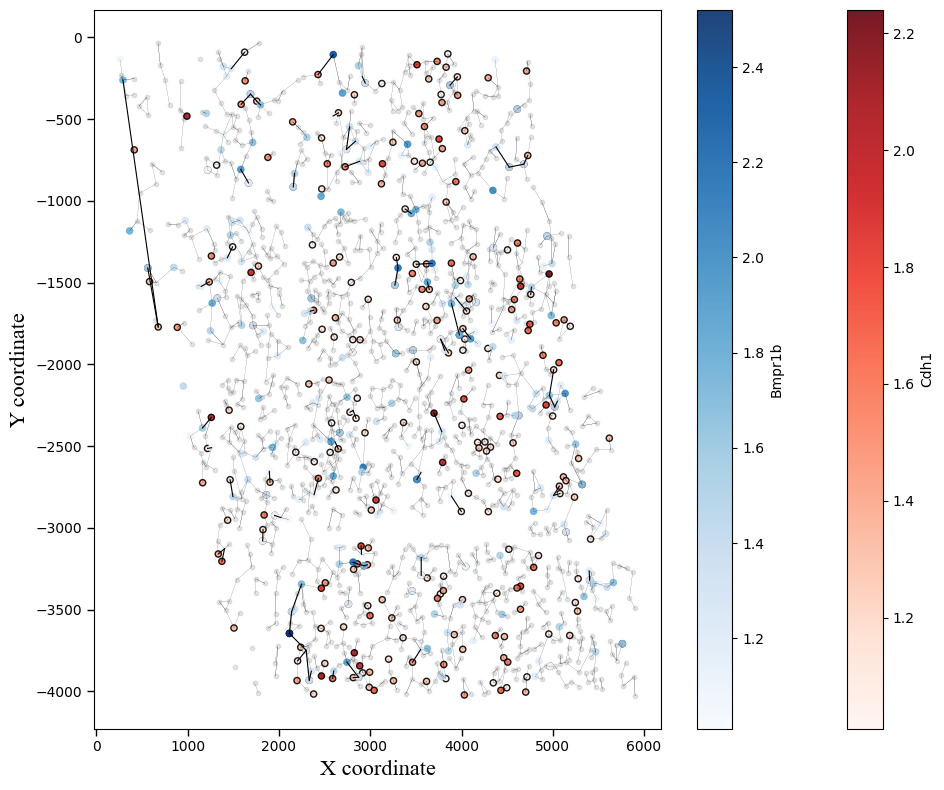

In [39]:
import pandas as pd
import numpy as np
count_df = starting_df.drop(columns=['Cell_ID', 'X', 'Y', 'Cell_Type'])
def filter_gene_expression(count_df, expression_threshold=1.0, min_cells=100):
    """
    筛选表达量大于给定阈值的基因，并确保基因在至少 min_cells 个细胞中表达。
    此外，排除负数的基因表达值。
    """
    # 仅保留大于 expression_threshold 的基因表达值（大于0的基因表达）
    valid_gene_expression = count_df > expression_threshold  # 只筛选大于阈值的表达

    # 计算每个基因满足条件的细胞数
    cells_above_threshold = valid_gene_expression.sum(axis=0)  # 统计每个基因大于阈值的细胞数
    
    # 筛选出在至少 min_cells 个细胞中满足条件的基因
    filtered_count_df = count_df.loc[:, cells_above_threshold >= min_cells]
    
    return filtered_count_df

# 对 count_df 进行筛选
filtered_count_df = filter_gene_expression(count_df)
print(filtered_count_df.head())

def get_valid_cells(count_df, gene1, gene2, selected_cells):
    # 确保 selected_cells 是整数类型的列表，并转换为索引对象
    if isinstance(selected_cells, list) and all(isinstance(i, int) for i in selected_cells):
        selected_cells_index = count_df.index[selected_cells]  # 获取对应的索引
    else:
        selected_cells_index = selected_cells  # 如果已经是一个合适的索引

    # 筛选出配体基因表达大于1的细胞
    valid_cells_gene1 = count_df.loc[selected_cells_index, gene1] > 1  # 配体基因表达大于1
    valid_cells_gene1_ids = selected_cells_index[valid_cells_gene1].tolist()  # 配体基因有效细胞ID
    
    # 筛选出受体基因表达大于1的细胞
    valid_cells_gene2 = count_df.loc[selected_cells_index, gene2] > 1  # 受体基因表达大于1
    valid_cells_gene2_ids = selected_cells_index[valid_cells_gene2].tolist()  # 受体基因有效细胞ID
    
    return valid_cells_gene1_ids, valid_cells_gene2_ids

# 示例：获取 'Gdf5' 和 'Bmpr1b' 筛选后的细胞ID
selected_cells = list(filtered_count_df.index)  # 假设这些是您的有效细胞列表
gene1 = 'Cdh1'  # 替换为实际的基因名
gene2 = 'Bmpr1b'  # 替换为实际的基因名

#ligand="Gal", receptor="Galr1",
valid_cells_gene1_ids, valid_cells_gene2_ids = get_valid_cells(filtered_count_df, gene1, gene2, selected_cells)

# print(f"Valid cells for ligand gene {gene1}: {valid_cells_gene1_ids}")
# print(f"Valid cells for receptor gene {gene2}: {valid_cells_gene2_ids}")

fig = visualize_celllevel_graph_with_colored_nodes(
    df=starting_df, 
    edge_trace=edges4,  # 边的坐标
    edge_weights=combined_edge_weights,  # 边的权重
    selected_cells_1=valid_cells_gene1_ids,  # 配体基因的细胞ID
    selected_cells_2=valid_cells_gene2_ids,  # 受体基因的细胞ID
gene1 = 'Cdh1',  # 替换为实际的基因名
gene2 = 'Bmpr1b',  # 替换为实际的基因名
    figsize=(10, 8),
    markersize=20
)


C:\Users\R9000\AppData\Local\Temp\ipykernel_27440\2665656740.py:83: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

C:\Users\R9000\AppData\Local\Temp\ipykernel_27440\2665656740.py:87: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



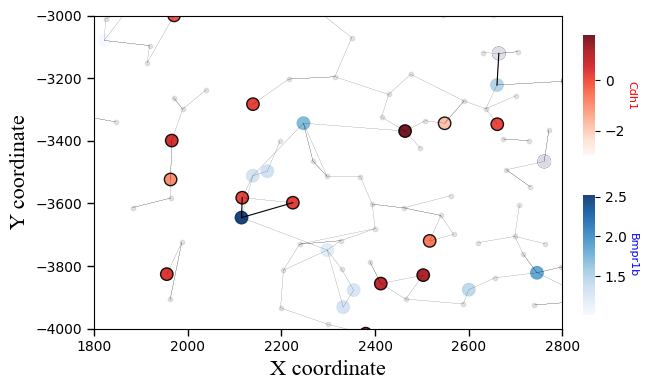

In [50]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_celllevel_graph_with_colored_nodes1(df, edge_trace=None, edge_weights=None, 
                                                 selected_cells_1=None, selected_cells_2=None, 
                                                 gene1=None, gene2=None, figsize=(10, 8), 
                                                 markersize=10, xlim=None, ylim=None, publication=False, save_path=None):

    fig, ax = plt.subplots(figsize=figsize)

    # 获取 selected_cells_1 的 X 和 Y 坐标
    selected_cells_1_x = df.loc[selected_cells_1, 'X'].values
    selected_cells_1_y = df.loc[selected_cells_1, 'Y'].values
    selected_cells_2_x = df.loc[selected_cells_2, 'X'].values
    selected_cells_2_y = df.loc[selected_cells_2, 'Y'].values

    # 绘制背景细胞（未选中的细胞）
    all_cells = set(df.index)  
    background_cells = list(all_cells - set(selected_cells_1) - set(selected_cells_2))

    if background_cells:
        ax.scatter(df.loc[background_cells, 'X'], 
                   df.loc[background_cells, 'Y'],
                   s=10, color='gray', alpha=0.2, label="Background Cells")

    # 绘制配体基因表达最强的细胞
    if selected_cells_1 is not None and gene1 is not None:
        gene1_values = np.array(df.loc[selected_cells_1, gene1].values)
        scatter1 = ax.scatter(df.loc[selected_cells_1, 'X'], 
                              df.loc[selected_cells_1, 'Y'],
                              s=markersize, c=gene1_values, cmap='Reds', edgecolors='black', alpha=0.9, label='Ligand Cells')

        # Adjust colorbar for gene1
        cbar_ax1 = fig.add_axes([0.98, 0.6, 0.02, 0.3])  # Manually place the colorbar for gene1
        cbar1 = plt.colorbar(scatter1, cax=cbar_ax1)
        cbar1.set_label(gene1, color='red', rotation=270, labelpad=8, fontsize=8)
        cbar1.outline.set_visible(False)  # Hide the outline of the colorbar

    # 绘制受体基因表达最强的细胞
    if selected_cells_2 is not None and gene2 is not None:
        gene2_values = np.array(df.loc[selected_cells_2, gene2].values)
        scatter2 = ax.scatter(df.loc[selected_cells_2, 'X'], 
                              df.loc[selected_cells_2, 'Y'],
                              s=markersize, c=gene2_values, cmap='Blues', alpha=0.9, label='Receptor Cells')

        # Adjust colorbar for gene2
        cbar_ax2 = fig.add_axes([0.98, 0.2, 0.02, 0.3])  # Manually place the colorbar for gene2
        cbar2 = plt.colorbar(scatter2, cax=cbar_ax2)
        cbar2.set_label(gene2, color='blue', rotation=270, labelpad=8, fontsize=8)
        cbar2.outline.set_visible(False)  # Hide the outline of the colorbar

    # 清理 edge_trace 数据，提取有效的 edge_x 和 edge_y
    if edge_trace is not None:
        edge_x, edge_y = edge_trace  # 解包坐标数据

        # 遍历所有边的坐标，提取有效的坐标对
        for i in range(0, len(edge_x) - 1, 2):  # 确保不会超出范围
            x1, y1 = edge_x[i], edge_y[i]
            x2, y2 = edge_x[i + 1], edge_y[i + 1]

            # 检查每个端点是否在 selected_cells_1 和 selected_cells_2 中
            if (x1 in selected_cells_1_x and y1 in selected_cells_1_y) and (x2 in selected_cells_2_x and y2 in selected_cells_2_y):
                linewidth = 0.8  # 如果两端点都在 selected_cells_1 和 selected_cells_2 中，加粗边
            else:
                linewidth = 0.1  # 默认边宽

            # 绘制每一条边
            ax.plot([x1, x2], [y1, y2], color='black', lw=linewidth)

    # 设置坐标轴限制
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)

    # 设置出版风格的布局
    ax.set_xlabel("X coordinate", fontsize=16, family="Times New Roman")
    ax.set_ylabel("Y coordinate", fontsize=16, family="Times New Roman")
    ax.tick_params(axis='both', which='both', length=5, width=1)

    # Save the plot to a file if save_path is provided
    if save_path:
        plt.tight_layout()
        plt.savefig(save_path, dpi=900, bbox_inches='tight')

   # Optionally, close the figure to avoid it being displayed interactively
    plt.tight_layout()
    plt.show()
    
    return fig

    # Call the function and save the plot
save_path = "Cell_Interaction_Graph.png"
fig = visualize_celllevel_graph_with_colored_nodes1(
        df=starting_df, 
        edge_trace=edges4,  # 边的坐标
        edge_weights=combined_edge_weights,  # 边的权重
        selected_cells_1=valid_cells_gene1_ids,  # 配体基因的细胞ID
        selected_cells_2=valid_cells_gene2_ids,  # 受体基因的细胞ID
    gene1 = 'Cdh1',  # 替换为实际的基因名
    gene2 = 'Bmpr1b',  # 替换为实际的基因名
        figsize=(6, 4),
        xlim=(1800, 2800),
        ylim=(-4000,-3000),
        markersize=80,
        save_path=save_path  # Provide save path to save the figure
    )


In [ ]:
ligand_receptor_pairs = [('Gdf5', 'Bmpr1b'),('Gdf2', 'Bmpr1b'),('Cdh1', 'Bmpr1b'),('Ctla4', 'Bmpr1b')]

   4931431F19Rik  4932429P05Rik  Abca15  Abca9  Adcy4  Aldh3b2  Ankle1  Ano7  \
0           1.83           1.52    2.41  -0.02  -0.28     1.95    0.04  0.10   
1           0.38          -0.04    0.59   0.03   0.93     0.49    0.08  2.05   
2           0.82           0.12    0.67  -0.29  -0.42    -0.04    1.35  0.68   
3           0.04          -1.27   -0.30  -0.52  -2.08     0.92   -0.03  0.42   
4           0.52           0.44   -1.05   0.48  -0.49     2.29    0.27  0.67   

   Anxa9  Arhgef26  ...  calb1   gda  slc5a7  sema3e  mfge8  lyve1  loxl1  \
0   0.91     -0.24  ...   0.12 -1.32   -2.06   -1.32   0.19  -2.20  -1.54   
1  -0.17     -0.11  ...  -1.60 -0.64   -2.47   -1.34   0.00   0.22  -1.46   
2   0.08      0.05  ...  -0.66 -0.78   -1.07   -2.09   0.09   0.32  -2.29   
3  -0.27      0.30  ...  -0.85 -1.16   -1.29   -0.57   0.99  -0.19  -1.49   
4  -1.00      0.43  ...  -0.65 -0.97   -1.29   -1.77   1.09  -1.17  -2.11   

   slco1c1  amigo2  kcnip  
0    -1.40    2.51   0.60  


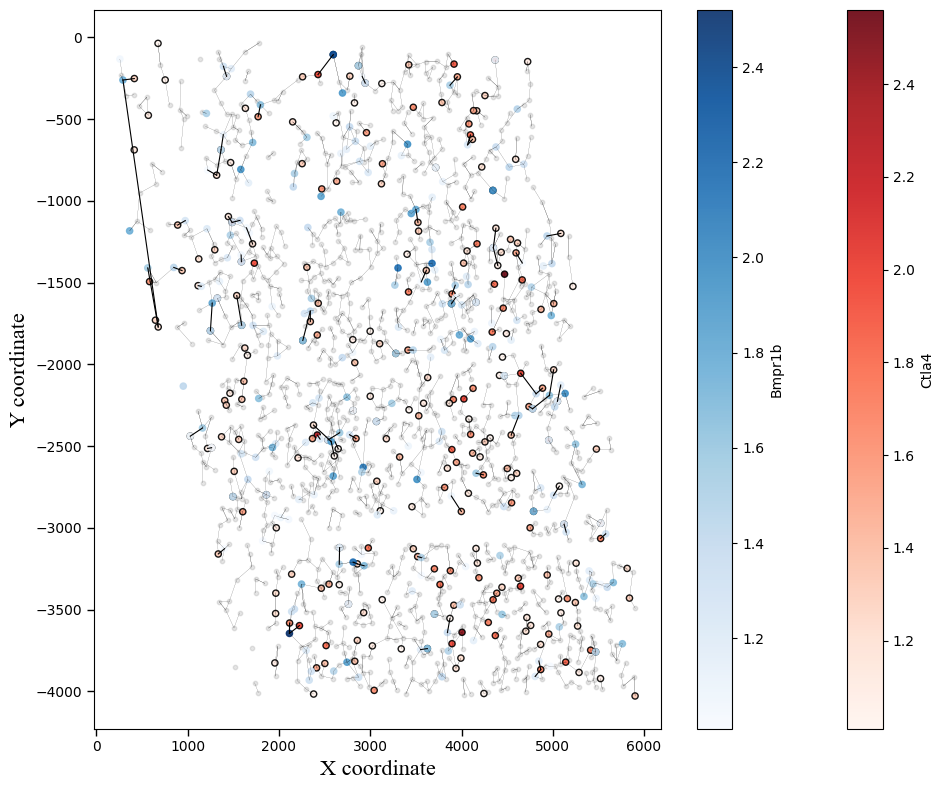

In [43]:
import pandas as pd
import numpy as np
count_df = starting_df.drop(columns=['Cell_ID', 'X', 'Y', 'Cell_Type'])
def filter_gene_expression(count_df, expression_threshold=1.0, min_cells=100):
    """
    筛选表达量大于给定阈值的基因，并确保基因在至少 min_cells 个细胞中表达。
    此外，排除负数的基因表达值。
    """
    # 仅保留大于 expression_threshold 的基因表达值（大于0的基因表达）
    valid_gene_expression = count_df > expression_threshold  # 只筛选大于阈值的表达

    # 计算每个基因满足条件的细胞数
    cells_above_threshold = valid_gene_expression.sum(axis=0)  # 统计每个基因大于阈值的细胞数
    
    # 筛选出在至少 min_cells 个细胞中满足条件的基因
    filtered_count_df = count_df.loc[:, cells_above_threshold >= min_cells]
    
    return filtered_count_df

# 对 count_df 进行筛选
filtered_count_df = filter_gene_expression(count_df)
print(filtered_count_df.head())

def get_valid_cells(count_df, gene1, gene2, selected_cells):
    # 确保 selected_cells 是整数类型的列表，并转换为索引对象
    if isinstance(selected_cells, list) and all(isinstance(i, int) for i in selected_cells):
        selected_cells_index = count_df.index[selected_cells]  # 获取对应的索引
    else:
        selected_cells_index = selected_cells  # 如果已经是一个合适的索引

    # 筛选出配体基因表达大于1的细胞
    valid_cells_gene1 = count_df.loc[selected_cells_index, gene1] > 1  # 配体基因表达大于1
    valid_cells_gene1_ids = selected_cells_index[valid_cells_gene1].tolist()  # 配体基因有效细胞ID
    
    # 筛选出受体基因表达大于1的细胞
    valid_cells_gene2 = count_df.loc[selected_cells_index, gene2] > 1  # 受体基因表达大于1
    valid_cells_gene2_ids = selected_cells_index[valid_cells_gene2].tolist()  # 受体基因有效细胞ID
    
    return valid_cells_gene1_ids, valid_cells_gene2_ids

# 示例：获取 'Gdf5' 和 'Bmpr1b' 筛选后的细胞ID
selected_cells = list(filtered_count_df.index)  # 假设这些是您的有效细胞列表
gene1 = 'Ctla4'  # 替换为实际的基因名
gene2 = 'Bmpr1b'  # 替换为实际的基因名

#ligand="Gal", receptor="Galr1",
valid_cells_gene1_ids, valid_cells_gene2_ids = get_valid_cells(filtered_count_df, gene1, gene2, selected_cells)

# print(f"Valid cells for ligand gene {gene1}: {valid_cells_gene1_ids}")
# print(f"Valid cells for receptor gene {gene2}: {valid_cells_gene2_ids}")

fig = visualize_celllevel_graph_with_colored_nodes(
    df=starting_df, 
    edge_trace=edges4,  # 边的坐标
    edge_weights=combined_edge_weights,  # 边的权重
    selected_cells_1=valid_cells_gene1_ids,  # 配体基因的细胞ID
    selected_cells_2=valid_cells_gene2_ids,  # 受体基因的细胞ID
gene1 = 'Ctla4',  # 替换为实际的基因名
gene2 = 'Bmpr1b',  # 替换为实际的基因名
    figsize=(10, 8),
    markersize=20
)


C:\Users\R9000\AppData\Local\Temp\ipykernel_27440\1454578232.py:83: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

C:\Users\R9000\AppData\Local\Temp\ipykernel_27440\1454578232.py:87: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



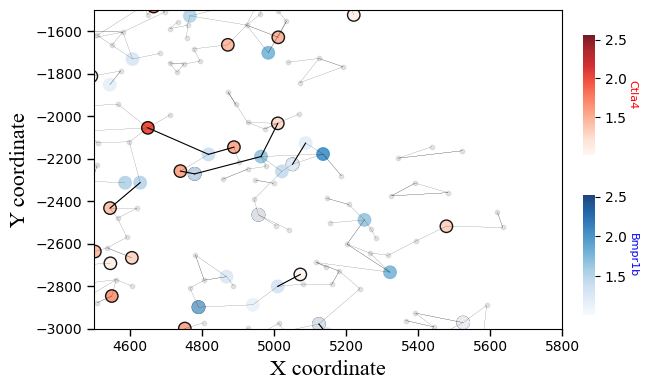

In [49]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_celllevel_graph_with_colored_nodes1(df, edge_trace=None, edge_weights=None, 
                                                 selected_cells_1=None, selected_cells_2=None, 
                                                 gene1=None, gene2=None, figsize=(10, 8), 
                                                 markersize=10, xlim=None, ylim=None, publication=False, save_path=None):

    fig, ax = plt.subplots(figsize=figsize)

    # 获取 selected_cells_1 的 X 和 Y 坐标
    selected_cells_1_x = df.loc[selected_cells_1, 'X'].values
    selected_cells_1_y = df.loc[selected_cells_1, 'Y'].values
    selected_cells_2_x = df.loc[selected_cells_2, 'X'].values
    selected_cells_2_y = df.loc[selected_cells_2, 'Y'].values

    # 绘制背景细胞（未选中的细胞）
    all_cells = set(df.index)  
    background_cells = list(all_cells - set(selected_cells_1) - set(selected_cells_2))

    if background_cells:
        ax.scatter(df.loc[background_cells, 'X'], 
                   df.loc[background_cells, 'Y'],
                   s=10, color='gray', alpha=0.2, label="Background Cells")

    # 绘制配体基因表达最强的细胞
    if selected_cells_1 is not None and gene1 is not None:
        gene1_values = np.array(df.loc[selected_cells_1, gene1].values)
        scatter1 = ax.scatter(df.loc[selected_cells_1, 'X'], 
                              df.loc[selected_cells_1, 'Y'],
                              s=markersize, c=gene1_values, cmap='Reds', edgecolors='black', alpha=0.9, label='Ligand Cells')

        # Adjust colorbar for gene1
        cbar_ax1 = fig.add_axes([0.98, 0.6, 0.02, 0.3])  # Manually place the colorbar for gene1
        cbar1 = plt.colorbar(scatter1, cax=cbar_ax1)
        cbar1.set_label(gene1, color='red', rotation=270, labelpad=8, fontsize=8)
        cbar1.outline.set_visible(False)  # Hide the outline of the colorbar

    # 绘制受体基因表达最强的细胞
    if selected_cells_2 is not None and gene2 is not None:
        gene2_values = np.array(df.loc[selected_cells_2, gene2].values)
        scatter2 = ax.scatter(df.loc[selected_cells_2, 'X'], 
                              df.loc[selected_cells_2, 'Y'],
                              s=markersize, c=gene2_values, cmap='Blues', alpha=0.9, label='Receptor Cells')

        # Adjust colorbar for gene2
        cbar_ax2 = fig.add_axes([0.98, 0.2, 0.02, 0.3])  # Manually place the colorbar for gene2
        cbar2 = plt.colorbar(scatter2, cax=cbar_ax2)
        cbar2.set_label(gene2, color='blue', rotation=270, labelpad=8, fontsize=8)
        cbar2.outline.set_visible(False)  # Hide the outline of the colorbar

    # 清理 edge_trace 数据，提取有效的 edge_x 和 edge_y
    if edge_trace is not None:
        edge_x, edge_y = edge_trace  # 解包坐标数据

        # 遍历所有边的坐标，提取有效的坐标对
        for i in range(0, len(edge_x) - 1, 2):  # 确保不会超出范围
            x1, y1 = edge_x[i], edge_y[i]
            x2, y2 = edge_x[i + 1], edge_y[i + 1]

            # 检查每个端点是否在 selected_cells_1 和 selected_cells_2 中
            if (x1 in selected_cells_1_x and y1 in selected_cells_1_y) and (x2 in selected_cells_2_x and y2 in selected_cells_2_y):
                linewidth = 0.8  # 如果两端点都在 selected_cells_1 和 selected_cells_2 中，加粗边
            else:
                linewidth = 0.1  # 默认边宽

            # 绘制每一条边
            ax.plot([x1, x2], [y1, y2], color='black', lw=linewidth)

    # 设置坐标轴限制
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)

    # 设置出版风格的布局
    ax.set_xlabel("X coordinate", fontsize=16, family="Times New Roman")
    ax.set_ylabel("Y coordinate", fontsize=16, family="Times New Roman")
    ax.tick_params(axis='both', which='both', length=5, width=1)

    # Save the plot to a file if save_path is provided
    if save_path:
        plt.tight_layout()
        plt.savefig(save_path, dpi=900, bbox_inches='tight')

   # Optionally, close the figure to avoid it being displayed interactively
    plt.tight_layout()
    plt.show()
    
    return fig

    # Call the function and save the plot
save_path = "Cell_Interaction_Graph.png"
fig = visualize_celllevel_graph_with_colored_nodes1(
        df=starting_df, 
        edge_trace=edges4,  # 边的坐标
        edge_weights=combined_edge_weights,  # 边的权重
        selected_cells_1=valid_cells_gene1_ids,  # 配体基因的细胞ID
        selected_cells_2=valid_cells_gene2_ids,  # 受体基因的细胞ID
    gene1 = 'Ctla4',  # 替换为实际的基因名
    gene2 = 'Bmpr1b',  # 替换为实际的基因名
        figsize=(6, 4),
        xlim=(4500, 5800),
        ylim=(-3000,-1500),
        markersize=80,
        save_path=save_path  # Provide save path to save the figure
    )


Output()

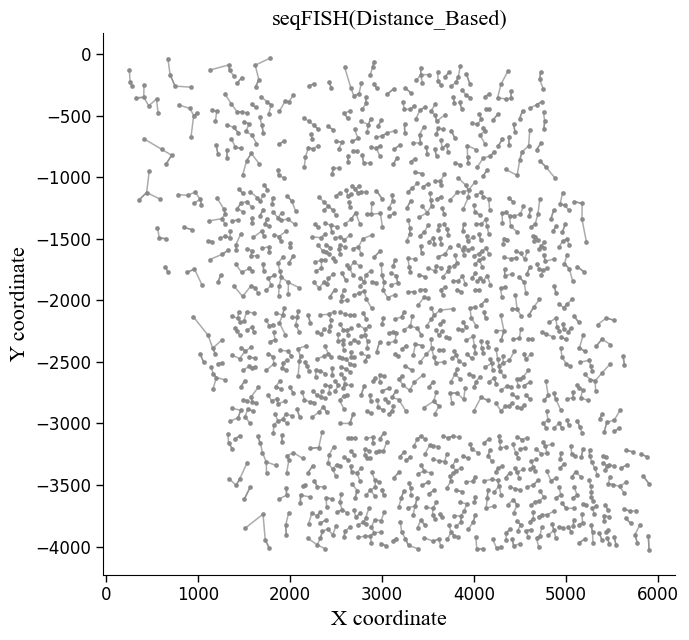

In [41]:
import matplotlib.pyplot as plt
import numpy as np

from rich.progress import track
def construct_celllevel_graph(data_df, k, get_edges=False):   # Top k closest neighbors for each cell
    '''
    Constructs new cell graph with spatial proximity edges based on kNN.
    
    :data_df: pd.DataFrame : represents the spatial data and contains the following columns ["Cell_ID", "X", "Y"]
    :k: int: Number of nearest neighbors to construct spatial edges for
    :get_edges: boolean:  True to return edge_trace (for visualization purposes)
    
    :return: Cell_level_adjacency, edge list
    '''
    
    adjacency = np.zeros(shape=(len(data_df), k),dtype=int) # shape = (numcells, numneighbors of cell)
    coords = np.vstack([data_df["X"].values,data_df["Y"].values]).T

    edges = None
    edge_x = []
    edge_y = []

    # for i in tqdm(range(len(data_df)), desc=f"2. Constructing Cell-Level Graph from ST Data", colour="cyan", position=1):
    for i in track(range(len(data_df)), description=f"[cyan]2. Constructing Cell-Level Graph from ST Data"):
        cell_id = data_df["Cell_ID"][i]
        x0, y0 = data_df["X"].values[i],data_df["Y"].values[i]
        candidate_cell = coords[i]
        candidate_neighbors = coords
        euclidean_distances = np.linalg.norm(candidate_neighbors - candidate_cell,axis=1)
        neighbors = np.argsort(euclidean_distances)[1:k+1]
        adjacency[i] = neighbors
        assert i not in adjacency[i]
        if get_edges:
            for ncell in adjacency[i]:
                x1, y1 = data_df["X"].values[ncell],data_df["Y"].values[ncell]
                edge_x.append(x0)
                edge_x.append(x1)
                edge_x.append(None)
                edge_y.append(y0)
                edge_y.append(y1)
                edge_y.append(None)
        
    edges=[edge_x,edge_y]
                
    return adjacency,edges
celllevel_adj, edges = construct_celllevel_graph(
    starting_df, k=2, get_edges=True
)
import plotly.graph_objects as go
import numpy as np
import plotly.express as px



# Enable interactive mode
plt.ion()

def visualize_celllevel_graph(df, title, edge_trace=None, edge_weights=1, publication=False):
    # Convert pixels to inches (for 100 DPI, 700px becomes 7 inches, 650px becomes 6.5 inches)
    figsize_in_inches = (700 / 100, 650 / 100)  # 700x650 pixels at 100 DPI
    
    # 创建一个新图形，设置大小为700x650像素（100 DPI）
    fig, ax = plt.subplots(figsize=figsize_in_inches)

    # 绘制细胞散点图，所有点的颜色统一为灰色
    ax.scatter(df["X"], df["Y"], color="gray", s=6, alpha=0.8, label="Cells")

    # 如果有边的坐标信息，添加边的描绘
    if edge_trace is not None:
        for i in range(0, len(edge_trace[0]), 2):
            x0, y0 = edge_trace[0][i], edge_trace[1][i]
            x1, y1 = edge_trace[0][i+1], edge_trace[1][i+1]
            ax.plot([x0, x1], [y0, y1], color='#888', lw=1.1, alpha=0.7)

    # 设置标题
    ax.set_title(title, fontsize=16, family="Times New Roman", color="black")
    ax.set_xlabel("X coordinate", fontsize=16, family="Times New Roman")
    ax.set_ylabel("Y coordinate", fontsize=16, family="Times New Roman")

    # 设置坐标轴样式
    ax.tick_params(axis='both', which='both', length=5, width=1, labelsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # 设置出版风格的布局（清晰的白色背景，简洁的线条，去除不必要的元素）
    if not publication:
        ax.grid(False)  # 隐藏网格线

    # 如果需要出版风格，设置白色背景和没有图例
    else:
        ax.set_facecolor("white")
        ax.legend().set_visible(False)

    # 保存图像，增加DPI以提高分辨率
    plt.tight_layout()  # 自动调整布局
    plt.savefig("Cell_Interaction(Distance_based)_seq.png", dpi=300, bbox_inches='tight')  # 保存为高分辨率图像

    # 显示图形
    plt.show()

    return fig

sim_fig = visualize_celllevel_graph(
    starting_df, title="seqFISH(Distance_Based)", edge_trace=edges,
)
